# SAD VAE

In [1]:
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from sklearn.model_selection import train_test_split
from typing import Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import os
from pathlib import Path


### Normalization

In [2]:
def normalize(data: pd.DataFrame, features: list, feature_range: Tuple = None, scaler=None) -> (pd.DataFrame, any):
        if feature_range is not None and scaler is None:
            scaler = MinMaxScaler(feature_range=feature_range)
            scaler.fit(data)
        elif feature_range is None and scaler is None:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(data)

        data = scaler.transform(data)

        return pd.DataFrame(columns=features, data=data), scaler

### Split handler

In [3]:
def create_splits(input_data: pd.DataFrame, without_val: bool = False) -> Tuple:
        """
        Creates train val test split of the data provided
        @param input_data: The input data which should be split
        @param without_val: If true only a test and a train set will be created
        @return: A tuple containing all the sets.
        """

        # No validation set will be created
        if without_val:
            return train_test_split(input_data, test_size=0.2, random_state=1, shuffle=True)

        # Create validation set
        X_dev, X_val = train_test_split(input_data, test_size=0.05, random_state=1, shuffle=True)
        X_train, X_test = train_test_split(X_dev, test_size=0.25, random_state=1, shuffle=True)
        return X_train, X_val, X_test

### Create custom sampling layer

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Create VAE 

In [25]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder: Model = encoder
        self.decoder: Model = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_fn = keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.001* kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

### Adjust hyperparameters

In [26]:
latent_dim = 500 # Latent dims
data_path = "X_intersect_5k_mad_feats_cohorts_n25.tsv" # Path to you data
epochs = 100 # The number of epochs
batch_size = 128 # The batch size
base_path = "" # The base path where results are being stored
prefix = "" # The prefix used for result files

### Load data

In [27]:
data = pd.read_csv(data_path, sep='\t', index_col=0)
# truncate everything after the 4th decimal
data = np.trunc(1000 * data) / 1000

train_data, val_data, test_data = create_splits(input_data=data, without_val=False)

train_data, scaler = normalize(train_data, features=train_data.columns)
val_data, _ = normalize(val_data, features=val_data.columns, scaler=scaler)
test_data, _ = normalize(data=test_data, features=test_data.columns, scaler=scaler)

### Build model

In [28]:
input_dimensions = train_data.shape[1]

encoder_inputs = keras.Input(shape=(input_dimensions,))
x = layers.Dense(units=input_dimensions / 2, activation="relu")(encoder_inputs)
x = layers.Dense(units=input_dimensions / 3, activation="relu")(x)
x = layers.Dense(units=input_dimensions / 4, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(units=input_dimensions / 4, activation="relu")(latent_inputs)
x = layers.Dense(units=input_dimensions / 3, activation="relu")(x)
x = layers.Dense(units=input_dimensions / 2, activation="relu")(x)

decoder_outputs = layers.Dense(units=input_dimensions, activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae: VAE = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# vae.summary()

callbacks = []

early_stop = EarlyStopping(monitor="reconstruction_loss",
                           mode="min", patience=5,
                           restore_best_weights=True)
callbacks.append(early_stop)

csv_logger = CSVLogger(os.path.join(base_path, 'training.log'),
                       separator='\t')
callbacks.append(csv_logger)

history = vae.fit(train_data,
                  callbacks=callbacks,
                  validation_data=(val_data, val_data),
                  epochs=epochs, batch_size=batch_size)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5000)]       0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 2500)         12502500    ['input_3[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 1666)         4166666     ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 1250)         2083750     ['dense_8[0][0]']                
                                                                                            

### Create embeddings for test data

In [29]:
z_mean, z_var, embedding = vae.encoder.predict(test_data)
embedding = pd.DataFrame(embedding)
embedding.to_csv(Path(base_path, f"{prefix}_embeddings.csv"), index=False)

60/60 [==============================] - 2s 24ms/step


### Plot model

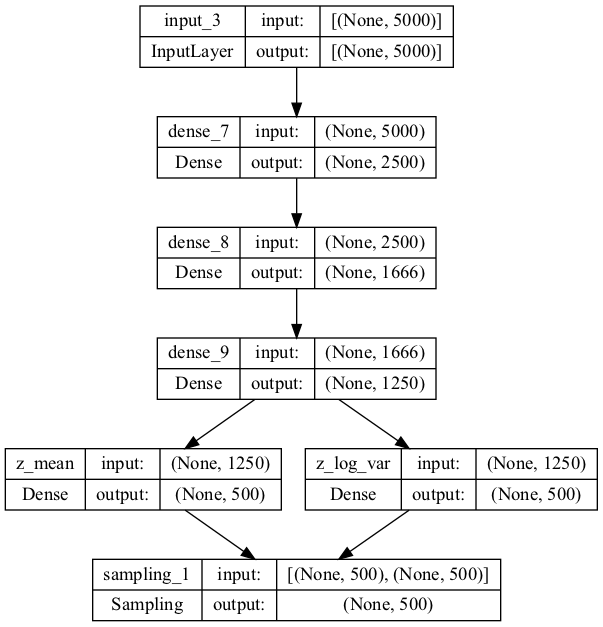

In [30]:
tf.keras.utils.plot_model(vae.encoder,  show_shapes=True)

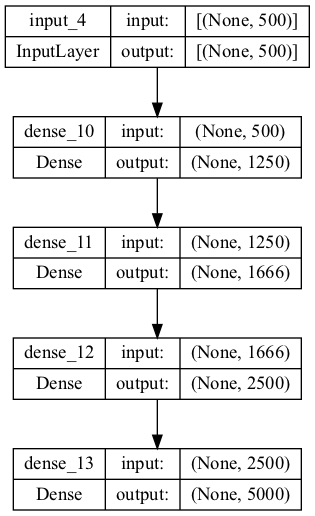

In [31]:
tf.keras.utils.plot_model(vae.decoder,  show_shapes=True)

In [32]:
import matplotlib.pyplot as plt

In [33]:
print(history.history)

{'loss': [0.740171492099762, 0.69864821434021, 0.6986528038978577, 0.6986230611801147, 0.6986350417137146, 0.6986481547355652, 0.6986278891563416, 0.6986382603645325, 0.6986296772956848], 'reconstruction_loss': [0.7027819156646729, 0.6986414790153503, 0.6986485123634338, 0.6986205577850342, 0.6986335515975952, 0.6986472606658936, 0.698627233505249, 0.6986379623413086, 0.6986294984817505], 'kl_loss': [37.389530181884766, 0.006853658705949783, 0.004230067599564791, 0.0024560962338000536, 0.0014180508442223072, 0.0008372425800189376, 0.0005138655542396009, 0.00033054419327527285, 0.00022361874289344996], 'val_total_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_reconstruction_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_kl_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


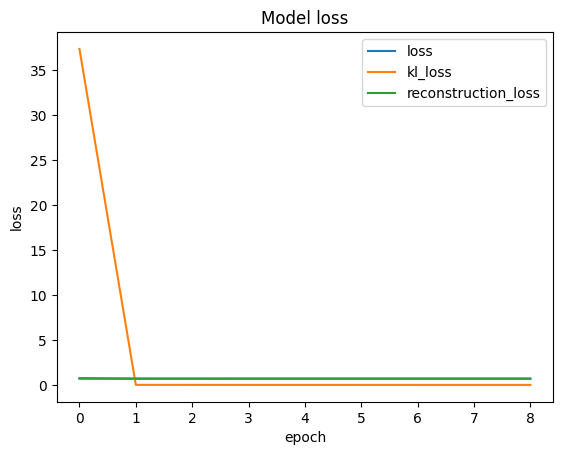

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['kl_loss'])
plt.plot(history.history['reconstruction_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'kl_loss', 'reconstruction_loss'], loc='upper right')
plt.show()